In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '50 percent More hold CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

## Train Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


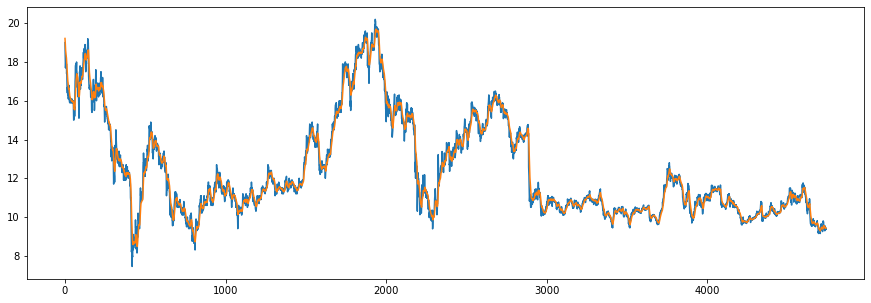

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


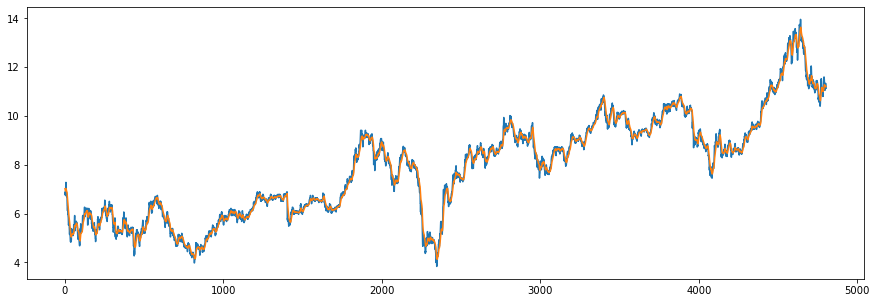

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


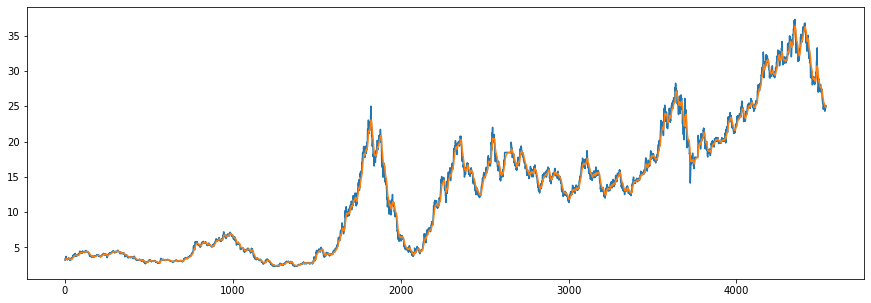

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


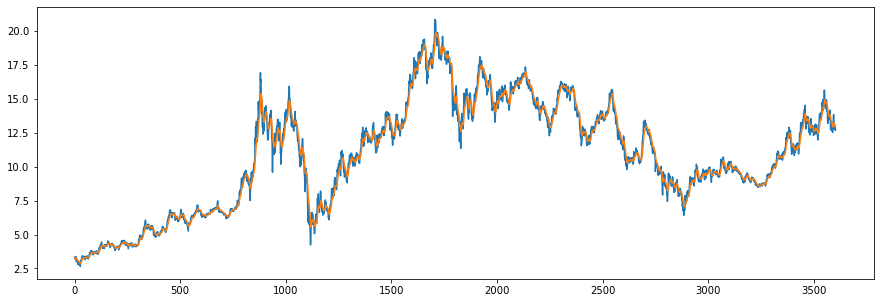

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


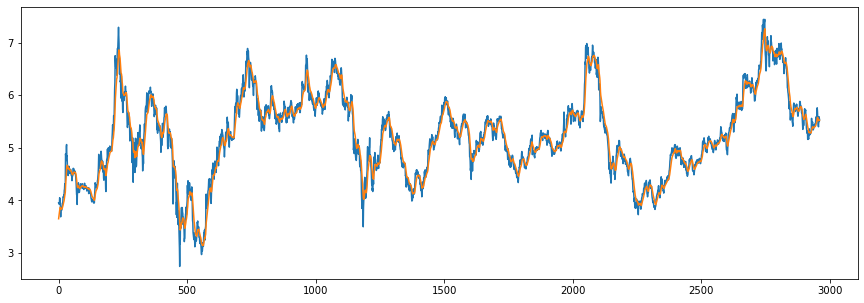

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


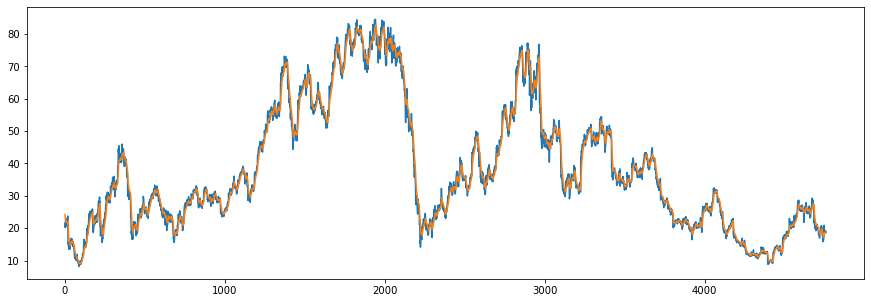

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


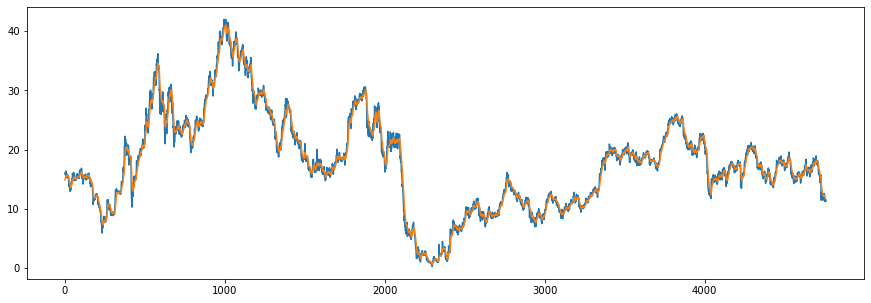

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


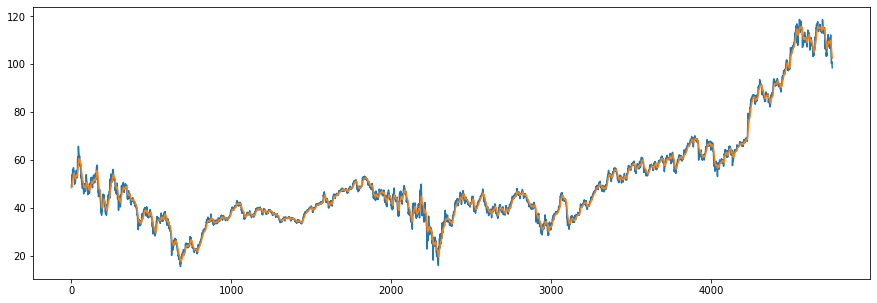

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


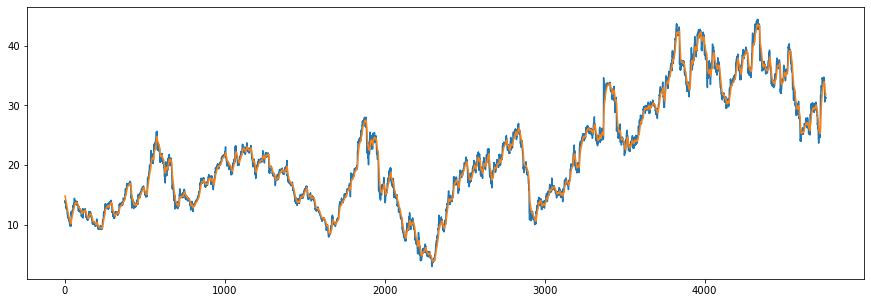

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


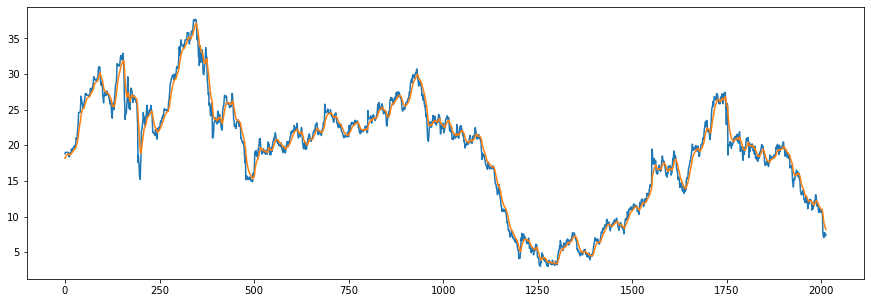

In [10]:
sequential_data = []
labels = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1
            
    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
        
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(41550, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [13]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:923]
class_1 = class_1[0:923]
class_2 = class_2[0:1845]

class_0_labels = class_0_labels[0:923]
class_1_labels = class_1_labels[0:923]
class_2_labels = class_2_labels[0:1845]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(3691, 64, 64, 1)


Counter({0.0: 923, 1.0: 923, 2.0: 1845})

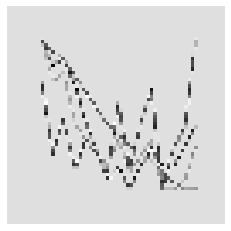

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 2 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 1.3333333333333333, 1: 1.3333333333333333, 2: 0.6666666666666666}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/24 [>.............................] - ETA: 0s - loss: 0.4687 - accuracy: 0.3828 - mse: 5.9539 - weighted_accuracy: 0.2923 - weighted_mse: 6.0485WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
24/24 [==============================] - 1s 34ms/step - loss: 0.2403 - accuracy: 0.3262 - mse: 1.6842 - weighted_accuracy: 0.3162 - weighted_mse: 1.6963 - val_loss: 0.1995 - val_accuracy: 0.2382 - val_mse: 0.9692 - val_weighted_accuracy: 0.2382 - val_weighted_mse: 0.9692
Epoch 2/20
24/24 [==============================] - 0s 14ms/step - loss: 0.2042 - accuracy: 0.3008 - mse: 1.1734 - weighted_accuracy: 0.3105 - weighted_mse: 1.1688 - val_loss: 0.1969

7/7 [==============================] - 0s 9ms/step - loss: 0.1861 - accuracy: 0.1349 - mse: 0.9701 - weighted_accuracy: 0.1349 - weighted_mse: 0.9701
Test loss: 0.18614263832569122
Test accuracy: 0.13488371670246124


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 121
actual holds but predicted sell: 60
actual predicted holds: 17
Percentage buys correct: 5.343511450381679%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 89.47368421052632%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 43.51145038167939%
Percentage high sells correct: 56.92307692307692%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price

1         -55.902029  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1859 - accuracy: 0.1628 - mse: 0.9877 - weighted_accuracy: 0.1628 - weighted_mse: 0.9877
Test loss: 0.1859334409236908
Test accuracy: 0.1627907007932663


number of predictions: 215
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 113
actual holds but predicted sell: 60
actual predicted holds: 20
Percentage buys correct: 7.936507936507937%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 86.95652173913044%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.20634920634921%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 73.91304347826087%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at

7/7 [==============================] - 0s 11ms/step - loss: 0.1872 - accuracy: 0.1268 - mse: 0.9793 - weighted_accuracy: 0.1268 - weighted_mse: 0.9793
Test loss: 0.1871689260005951
Test accuracy: 0.1267605572938919


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 116
actual holds but predicted sell: 60
actual predicted holds: 17
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 80.95238095238095%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.07275374955355574


Pric


Price increase from previously bought: 5.8327896394246626%
Share price: $0.9139493058221533
Shares owned at the moment: 0
Cash capital at the moment: $13976.981144472322




Capital at the end of test period: $13976.981144472322
profit gained: 13876.981144472322%


Capital at the end of test period if Buy and Hold: $1676.1791664809543
profit gained: 1576.1791664809543%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.215596      8.490566       6.329114     100.000000   
1       0.110092      6.722689       6.896552      83.333333   
2       0.137441      4.132231       4.411765      95.454545   
3       0.201835      8.411215       2.666667      91.666667   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         49.523810           41.772152          75.757576      38.857476   
1         51.260504           51.162791          83.333333     -86.324591   
2         45.454545           52.238806          86.363636      92.008766  

7/7 [==============================] - 0s 6ms/step - loss: 0.1862 - accuracy: 0.1735 - mse: 0.9745 - weighted_accuracy: 0.1735 - weighted_mse: 0.9745
Test loss: 0.1862017661333084
Test accuracy: 0.17351597547531128


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 106
actual holds but predicted sell: 68
actual predicted holds: 23
Percentage buys correct: 8.403361344537815%
Percentage sells correct: 6.8493150684931505%
Percentage holds correct: 85.18518518518519%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 46.610169491525426%
Percentage high sells correct: 57.534246575342465%
Percentage mid holds correct: 77.77777777777777%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


P

Epoch 9/20
24/24 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.3917 - mse: 1.3000 - weighted_accuracy: 0.4664 - weighted_mse: 1.283 - 0s 12ms/step - loss: 0.1865 - accuracy: 0.3916 - mse: 1.3048 - weighted_accuracy: 0.4670 - weighted_mse: 1.2900 - val_loss: 0.1829 - val_accuracy: 0.4046 - val_mse: 1.0606 - val_weighted_accuracy: 0.4046 - val_weighted_mse: 1.0606
Epoch 10/20
24/24 [==============================] - 0s 17ms/step - loss: 0.1875 - accuracy: 0.3926 - mse: 1.2649 - weighted_accuracy: 0.4779 - weighted_mse: 1.2526 - val_loss: 0.1857 - val_accuracy: 0.3938 - val_mse: 1.0200 - val_weighted_accuracy: 0.3938 - val_weighted_mse: 1.0200
Epoch 11/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1860 - accuracy: 0.3882 - mse: 1.2818 - weighted_accuracy: 0.4724 - weighted_mse: 1.2722 - val_loss: 0.1866 - val_accuracy: 0.3829 - val_mse: 1.2065 - val_weighted_accuracy: 0.3829 - val_weighted_mse: 1.2065
Epoch 12/20
24/24 [======================

7/7 [==============================] - 0s 13ms/step - loss: 0.1978 - accuracy: 0.0698 - mse: 1.2730 - weighted_accuracy: 0.0698 - weighted_mse: 1.2730
Test loss: 0.19779625535011292
Test accuracy: 0.06976744532585144


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 118
actual holds but predicted sell: 80
actual predicted holds: 0
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 8.98876404494382%
Percentage holds correct: 0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.23809523809524%
Percentage high sells correct: 56.81818181818182%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: 

Share price: $0.7216562981408023
Shares owned at the moment: 180
Cash capital at the moment: $0.23221063565574696


Price increase from previously bought: 1.4212960320358015%
Share price: $0.73392593169001
Shares owned at the moment: 0
Cash capital at the moment: $131.97558500367097


Share price: $0.8198157068393652
Shares owned at the moment: 160
Cash capital at the moment: $0.44435299836322883


Price increase from previously bought: 0.47205410422999083%
Share price: $0.8259508161520819
Shares owned at the moment: 0
Cash capital at the moment: $132.2330652235894


Share price: $0.611226670816807
Shares owned at the moment: 215
Cash capital at the moment: $0.45794322885541305


Price increase from previously bought: -34.30695402109137%
Share price: $0.40263763479424886
Shares owned at the moment: 0
Cash capital at the moment: $86.78697520804683


Share price: $0.3658281490704012
Shares owned at the moment: 236
Cash capital at the moment: $0.21410955868546466


Price increase from pre

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2013 - accuracy: 0.0427 - mse: 1.3142 - weighted_accuracy: 0.0427 - weighted_mse: 1.3142
Test loss: 0.2012845128774643
Test accuracy: 0.04265403002500534


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 110
actual holds but predicted sell: 84
actual predicted holds: 0
Percentage buys correct: 3.389830508474576%
Percentage sells correct: 5.376344086021505%
Percentage holds correct: 0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 47.45762711864407%
Percentage high sells correct: 51.08695652173913%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016



JPM


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2009 - accuracy: 0.0688 - mse: 1.3275 - weighted_accuracy: 0.0688 - weighted_mse: 1.3275
Test loss: 0.20090259611606598
Test accuracy: 0.06880734115839005


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 82
actual holds but predicted sell: 119
actual predicted holds: 0
Percentage buys correct: 10.75268817204301%
Percentage sells correct: 4.0%
Percentage holds correct: 0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 46.236559139784944%
Percentage high sells correct: 45.96774193548387%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase fro

Share price: $0.689158932045216
Shares owned at the moment: 0
Cash capital at the moment: $130.4646607678014




Capital at the end of test period: $130.4646607678014
profit gained: 30.464660767801405%


Capital at the end of test period if Buy and Hold: $68.09965200824497
profit gained: -31.90034799175503%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.069767      5.555556       8.988764            0.0   
1       0.088372      8.403361       9.375000            0.0   
2       0.065728      5.833333       7.608696            0.0   
3       0.086758      7.826087       9.615385            0.0   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         45.238095           56.818182                0.0     -89.880893   
1         51.260504           54.736842                0.0     -23.586047   
2         47.500000           50.549451                0.0     -45.470304   
3         49.122807           50.961538                0.0    

7/7 [==============================] - 0s 5ms/step - loss: 0.1982 - accuracy: 0.0868 - mse: 1.2917 - weighted_accuracy: 0.0868 - weighted_mse: 1.2917
Test loss: 0.19815611839294434
Test accuracy: 0.08675798773765564


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 96
actual holds but predicted sell: 101
actual predicted holds: 0
Percentage buys correct: 9.25925925925926%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 51.401869158878505%
Percentage high sells correct: 56.75675675675676%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously bough

Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1782 - accuracy: 0.4123 - mse: 1.3505 - weighted_accuracy: 0.5181 - weighted_mse: 1.3362 - val_loss: 0.1813 - val_accuracy: 0.4154 - val_mse: 1.0898 - val_weighted_accuracy: 0.4154 - val_weighted_mse: 1.0898
Epoch 4/20
24/24 [==============================] - 0s 12ms/step - loss: 0.1777 - accuracy: 0.4079 - mse: 1.3497 - weighted_accuracy: 0.5167 - weighted_mse: 1.3359 - val_loss: 0.1801 - val_accuracy: 0.4127 - val_mse: 1.1204 - val_weighted_accuracy: 0.4127 - val_weighted_mse: 1.1204
Epoch 5/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1769 - accuracy: 0.4140 - mse: 1.3628 - weighted_accuracy: 0.5194 - weighted_mse: 1.3545 - val_loss: 0.1817 - val_accuracy: 0.4114 - val_mse: 1.0447 - val_weighted_accuracy: 0.4114 - val_weighted_mse: 1.0447
Epoch 6/20
24/24 [==============================] - 0s 12ms/step - loss: 0.1764 - accuracy: 0.4133 - mse: 1.3771 - weighted_accuracy: 0.5215 - weighted

7/7 [==============================] - 0s 32ms/step - loss: 0.2025 - accuracy: 0.0977 - mse: 1.3183 - weighted_accuracy: 0.0977 - weighted_mse: 1.3183
Test loss: 0.20247873663902283
Test accuracy: 0.0976744219660759


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 119
actual holds but predicted sell: 73
actual predicted holds: 6
Percentage buys correct: 5.511811023622047%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.669291338582674%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously 



Price increase from previously bought: 6.692447089854436%
Share price: $0.1879140745352006
Shares owned at the moment: 0
Cash capital at the moment: $34.307713751429034


Share price: $0.5498773329183202
Shares owned at the moment: 62
Cash capital at the moment: $0.12156502523060908


Price increase from previously bought: 14.190060528495074%
Share price: $0.629631998754957
Shares owned at the moment: 0
Cash capital at the moment: $39.05139669225022


Share price: $0.6419016323041646
Shares owned at the moment: 60
Cash capital at the moment: $0.43138498467016007


Price increase from previously bought: -95.58704284032893%
Share price: $0.028404742861924286
Shares owned at the moment: 0
Cash capital at the moment: $2.1309827738133995


Share price: $0.05294459503656523
Shares owned at the moment: 40
Cash capital at the moment: $0.0073750668967682564


Price increase from previously bought: 57.50471473911387%
Share price: $0.08361955652392193
Shares owned at the moment: 0
Cash capital 

0883.HK


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2077 - accuracy: 0.0948 - mse: 1.3641 - weighted_accuracy: 0.0948 - weighted_mse: 1.3641
Test loss: 0.20769160985946655
Test accuracy: 0.09478673338890076


number of predictions: 211
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 110
actual holds but predicted sell: 74
actual predicted holds: 10
Percentage buys correct: 4.201680672268908%
Percentage sells correct: 6.172839506172839%
Percentage holds correct: 90.9090909090909%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 50.42016806722689%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.01675890

Share price: $0.23727270902826936
Shares owned at the moment: 243
Cash capital at the moment: $0.22996761145380162


Price increase from previously bought: -35.65304562655914%
Share price: $0.15309762566404994
Shares owned at the moment: 0
Cash capital at the moment: $37.330383159467935




Capital at the end of test period: $37.330383159467935
profit gained: -62.66961684053206%


Capital at the end of test period if Buy and Hold: $15.710112504960433
profit gained: -84.28988749503957%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.097674      5.511811       9.756098     100.000000   
1       0.116279      8.264463      10.227273     100.000000   
2       0.112676      6.086957       8.045977      90.909091   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         45.669291           55.555556         100.000000     -88.805745   
1         52.066116           56.321839          83.333333     -47.716528   
2         47.826087   

Cash capital at the moment: $36.36614055470364


Share price: $0.2808156840786431
Shares owned at the moment: 129
Cash capital at the moment: $0.04129794463177916


Price increase from previously bought: 19.05699542855508%
Share price: $0.3352501256256053
Shares owned at the moment: 0
Cash capital at the moment: $43.16963416826918


Share price: $0.3201577164137164
Shares owned at the moment: 134
Cash capital at the moment: $0.15052205033272514


Price increase from previously bought: -1.858912377027988%
Share price: $0.3150703322260342
Shares owned at the moment: 0
Cash capital at the moment: $42.253843151196016


Share price: $0.30862642438218346
Shares owned at the moment: 136
Cash capital at the moment: $0.16522315250013264


Price increase from previously bought: 21.643862884332975%
Share price: $0.3764575235376586
Shares owned at the moment: 0
Cash capital at the moment: $51.22265123981862


Share price: $0.3371154912025851
Shares owned at the moment: 151
Cash capital at the mome

Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2011 - accuracy: 0.1461 - mse: 1.3280 - weighted_accuracy: 0.1461 - weighted_mse: 1.3280
Test loss: 0.20114174485206604
Test accuracy: 0.14611871540546417


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 91
actual holds but predicted sell: 93
actual predicted holds: 13
Percentage buys correct: 9.70873786407767%
Percentage sells correct: 8.737864077669903%
Percentage holds correct: 100.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 52.94117647058823%
Percentage high sells correct: 57.28155339805825%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increa

Epoch 4/20
24/24 [==============================] - 0s 17ms/step - loss: 0.1655 - accuracy: 0.4556 - mse: 1.4640 - weighted_accuracy: 0.5763 - weighted_mse: 1.4539 - val_loss: 0.1756 - val_accuracy: 0.4357 - val_mse: 1.3380 - val_weighted_accuracy: 0.4357 - val_weighted_mse: 1.3380
Epoch 5/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1649 - accuracy: 0.4526 - mse: 1.4697 - weighted_accuracy: 0.5732 - weighted_mse: 1.4630 - val_loss: 0.1755 - val_accuracy: 0.4371 - val_mse: 1.2547 - val_weighted_accuracy: 0.4371 - val_weighted_mse: 1.2547
Epoch 6/20
24/24 [==============================] - 0s 12ms/step - loss: 0.1673 - accuracy: 0.4492 - mse: 1.4170 - weighted_accuracy: 0.5653 - weighted_mse: 1.4058 - val_loss: 0.1756 - val_accuracy: 0.4330 - val_mse: 1.2869 - val_weighted_accuracy: 0.4330 - val_weighted_mse: 1.2869
Epoch 7/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1651 - accuracy: 0.4533 - mse: 1.4204 - weighted_accuracy: 0.5727 - weighted

Cash capital at the moment: $30.170210506798238


Share price: $0.3724161374520112
Shares owned at the moment: 80
Cash capital at the moment: $0.29498796039790065


Price increase from previously bought: -16.448932698772655%
Share price: $0.3120133412016799
Shares owned at the moment: 0
Cash capital at the moment: $25.18741232146792


Share price: $0.305302417212735
Shares owned at the moment: 82
Cash capital at the moment: $0.08376841494218112


Price increase from previously bought: -0.27424582398405395%
Share price: $0.305302417212735
Shares owned at the moment: 0
Cash capital at the moment: $25.04972093130498


Share price: $0.2516111850013243
Shares owned at the moment: 99
Cash capital at the moment: $0.07171247105726408


Price increase from previously bought: 15.685962995578251%
Share price: $0.2918792891348947
Shares owned at the moment: 0
Cash capital at the moment: $28.888297958944865




Capital at the end of test period: $28.888297958944865
profit gained: -71.11170204105514



Share price: $0.6419016323041646
Shares owned at the moment: 52
Cash capital at the moment: $0.16960886555098398


Price increase from previously bought: -87.0088765652793%
Share price: $0.08361955652392193
Shares owned at the moment: 0
Cash capital at the moment: $4.505868208212004


Share price: $0.25539852174640587
Shares owned at the moment: 17
Cash capital at the moment: $0.15215345763145915


Price increase from previously bought: -33.811496537262606%
Share price: $0.1695093316732772
Shares owned at the moment: 0
Cash capital at the moment: $3.0258875348214453


Share price: $0.07748444721120527
Shares owned at the moment: 38
Cash capital at the moment: $0.07338141606207405


Price increase from previously bought: 126.06105647549914%
Share price: $0.17564385590976817
Shares owned at the moment: 0
Cash capital at the moment: $6.729493157690694


Share price: $0.13269926087320294
Shares owned at the moment: 50
Cash capital at the moment: $0.07628396566048146


Price increase from

7/7 [==============================] - 0s 15ms/step - loss: 0.2080 - accuracy: 0.0948 - mse: 1.5499 - weighted_accuracy: 0.0948 - weighted_mse: 1.5499
Test loss: 0.20800228416919708
Test accuracy: 0.09478673338890076


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 114
actual holds but predicted sell: 71
actual predicted holds: 9
Percentage buys correct: 4.838709677419355%
Percentage sells correct: 6.410256410256411%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 50.0%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price increase from previous

Shares owned at the moment: 0
Cash capital at the moment: $56.44765087523541


Share price: $0.23727270902826936
Shares owned at the moment: 237
Cash capital at the moment: $0.059376347426400855




Capital at the end of test period: $36.24373225227969
profit gained: -63.75626774772031%


Capital at the end of test period if Buy and Hold: $15.710112504960433
profit gained: -84.28988749503957%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.106977      5.343511       8.219178      90.909091   
1       0.144186      8.130081      10.256410      92.857143   
2       0.150235      6.086957       8.860759      94.736842   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         45.801527           56.944444          81.818182     -84.531782   
1         50.406504           57.142857          92.857143     -48.472188   
2         48.695652           55.128205          84.210526     -63.756268   

   buy_n_hold profit  
0         -78.2

Cash capital at the moment: $0.10616059514062215


Price increase from previously bought: 32.950486752696825%
Share price: $0.42343063215425536
Shares owned at the moment: 0
Cash capital at the moment: $91.31565934496014


Share price: $0.6043700581008722
Shares owned at the moment: 150
Cash capital at the moment: $0.41084798086269814


Price increase from previously bought: 5.4060248246920795%
Share price: $0.6387943202218671
Shares owned at the moment: 0
Cash capital at the moment: $95.96649335705125


Share price: $0.6294674923369679
Shares owned at the moment: 152
Cash capital at the moment: $0.024317110035283918


Price increase from previously bought: -2.9339733220870245%
Share price: $0.6126793315217027
Shares owned at the moment: 0
Cash capital at the moment: $92.89547554075801


Share price: $0.6686400400759915
Shares owned at the moment: 138
Cash capital at the moment: $0.3694011150623311


Price increase from previously bought: 10.247231637462129%
Share price: $0.73918431592

   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.151376      8.571429       7.446809      89.473684   
1       0.146789      7.407407       8.510638     100.000000   
2       0.094787      4.838710       6.410256     100.000000   
3       0.114679     11.111111       3.448276      91.666667   
4       0.123853      5.454545       7.526882      93.333333   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         53.846154           45.744681          68.421053     -71.111702   
1         53.703704           55.913978          87.500000     -90.019157   
2         50.000000           57.142857          88.888889      52.450292   
3         45.555556           45.217391          83.333333    1195.210050   
4         46.363636           51.086957          93.333333     -61.083716   

   buy_n_hold profit  
0         -64.154600  
1         -55.902029  
2         -54.689601  
3        1576.179166  
4         -40.196200  
Recession Test

24/24 [==============================] - 1s 24ms/step - loss: 0.1596 - accuracy: 0.4719 - mse: 1.5048 - weighted_accuracy: 0.5935 - weighted_mse: 1.4999 - val_loss: 0.1747 - val_accuracy: 0.4452 - val_mse: 1.3584 - val_weighted_accuracy: 0.4452 - val_weighted_mse: 1.3584
Epoch 2/20
24/24 [==============================] - 0s 16ms/step - loss: 0.1588 - accuracy: 0.4712 - mse: 1.5025 - weighted_accuracy: 0.5942 - weighted_mse: 1.4956 - val_loss: 0.1729 - val_accuracy: 0.4398 - val_mse: 1.3864 - val_weighted_accuracy: 0.4398 - val_weighted_mse: 1.3864
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1584 - accuracy: 0.4695 - mse: 1.5177 - weighted_accuracy: 0.5935 - weighted_mse: 1.5105 - val_loss: 0.1747 - val_accuracy: 0.4520 - val_mse: 1.3770 - val_weighted_accuracy: 0.4520 - val_weighted_mse: 1.3770
Epoch 4/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1556 - accuracy: 0.4837 - mse: 1.5582 - weighted_accuracy: 0.6077 - weighted_mse: 1.553

Shares owned at the moment: 176
Cash capital at the moment: $0.21381241074760027


Price increase from previously bought: 6.450285438902648%
Share price: $0.3187249052406005
Shares owned at the moment: 0
Cash capital at the moment: $56.155132878956834


Share price: $0.4126848816355573
Shares owned at the moment: 135
Cash capital at the moment: $0.28946459584940243


Price increase from previously bought: 14.322156124474205%
Share price: $0.47308767788588857
Shares owned at the moment: 0
Cash capital at the moment: $63.980667310029226


Share price: $0.5402013981251648
Shares owned at the moment: 118
Cash capital at the moment: $0.06160697756816802


Price increase from previously bought: 3.442788903091265%
Share price: $0.5603360902419257
Shares owned at the moment: 0
Cash capital at the moment: $65.99943656483188


Share price: $0.285167725095975
Shares owned at the moment: 230
Cash capital at the moment: $0.2304912066344258


Price increase from previously bought: -40.17396810671349



O39.SI


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2097 - accuracy: 0.1376 - mse: 1.6598 - weighted_accuracy: 0.1376 - weighted_mse: 1.6598
Test loss: 0.20970547199249268
Test accuracy: 0.1376146823167801


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 86
actual holds but predicted sell: 101
actual predicted holds: 14
Percentage buys correct: 7.526881720430108%
Percentage sells correct: 8.181818181818182%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 54.83870967741935%
Percentage high sells correct: 55.04587155963303%
Percentage mid holds correct: 93.33333333333333%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the momen

Cash capital at the moment: $0.2439669440199097


Price increase from previously bought: 89.53644238281913%
Share price: $0.4825608581556373
Shares owned at the moment: 0
Cash capital at the moment: $73.39150694496772


Share price: $0.4459755295327186
Shares owned at the moment: 164
Cash capital at the moment: $0.05038513778261233


Price increase from previously bought: -9.818644467169758%
Share price: $0.4032927915164859
Shares owned at the moment: 0
Cash capital at the moment: $66.00851789751236


Share price: $0.3849999818278531
Shares owned at the moment: 170
Cash capital at the moment: $0.3785334952728192


Price increase from previously bought: 10.781851411277055%
Share price: $0.4276830105984313
Shares owned at the moment: 0
Cash capital at the moment: $72.88470348955137


Share price: $0.4215853104507723
Shares owned at the moment: 172
Cash capital at the moment: $0.17262024017531985


Price increase from previously bought: -6.043737625926893%
Share price: $0.3971950913688269

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2116 - accuracy: 0.1596 - mse: 1.6491 - weighted_accuracy: 0.1596 - weighted_mse: 1.6491
Test loss: 0.21155337989330292
Test accuracy: 0.15962441265583038


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 92
actual holds but predicted sell: 81
actual predicted holds: 20
Percentage buys correct: 6.930693069306931%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 95.23809523809524%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.504950495049506%
Percentage high sells correct: 52.22222222222222%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital 

Cash capital at the moment: $0.35683422293982403


Price increase from previously bought: 15.95321381252841%
Share price: $0.46605108293688047
Shares owned at the moment: 0
Cash capital at the moment: $1040.5108464457433


Share price: $0.3666879674219936
Shares owned at the moment: 2829
Cash capital at the moment: $0.29784589437190334


Price increase from previously bought: -39.21529257368965%
Share price: $0.22350315623739658
Shares owned at the moment: 0
Cash capital at the moment: $630.8494762102289


Share price: $0.18350315623739566
Shares owned at the moment: 3428
Cash capital at the moment: $0.07077237458656782


Price increase from previously bought: 38.771459784882765%
Share price: $0.25535029618578853
Shares owned at the moment: 0
Cash capital at the moment: $873.0044004573263


Share price: $0.518280275824534
Shares owned at the moment: 1679
Cash capital at the moment: $0.4187877443828256


Price increase from previously bought: -12.186923732061905%
Share price: $0.4563694

Shares owned at the moment: 119
Cash capital at the moment: $0.37783769986756965


Price increase from previously bought: -1.6491971206074152%
Share price: $0.38815842954279534
Shares owned at the moment: 0
Cash capital at the moment: $46.44166596939233


Share price: $0.3642479049892644
Shares owned at the moment: 127
Cash capital at the moment: $0.054968454938247646


Price increase from previously bought: -3.2456292037424617%
Share price: $0.3533949394745928
Shares owned at the moment: 0
Cash capital at the moment: $44.81270258560003


Share price: $0.2860725528623753
Shares owned at the moment: 156
Cash capital at the moment: $0.0626592138915214


Price increase from previously bought: 14.977516021758518%
Share price: $0.3298236428682695
Shares owned at the moment: 0
Cash capital at the moment: $51.37365315855107


Share price: $0.3947719513602499
Shares owned at the moment: 129
Cash capital at the moment: $0.308026083333786


Price increase from previously bought: 8.67889528409333

Share price: $0.225201411298246
Shares owned at the moment: 94
Cash capital at the moment: $0.0020224039446894437


Price increase from previously bought: 108.81098283924987%
Share price: $0.47153845482055323
Shares owned at the moment: 0
Cash capital at the moment: $44.20474446650557


Share price: $0.3918681361867874
Shares owned at the moment: 112
Cash capital at the moment: $0.19481782763985223


Price increase from previously bought: -6.799596156453247%
Share price: $0.3662270478452814
Shares owned at the moment: 0
Cash capital at the moment: $41.09944925557502


Share price: $0.32868127453506213
Shares owned at the moment: 124
Cash capital at the moment: $0.2308908986108591


Price increase from previously bought: 28.62210816701005%
Share price: $0.4239193656144522
Shares owned at the moment: 0
Cash capital at the moment: $52.6523357311284




Capital at the end of test period: $52.6523357311284
profit gained: -47.3476642688716%


Capital at the end of test period if Buy and Hold




RUNNING EPOCHS 100 - 120



Epoch 1/20
24/24 [==============================] - 0s 20ms/step - loss: 0.1541 - accuracy: 0.4831 - mse: 1.6300 - weighted_accuracy: 0.5994 - weighted_mse: 1.6344 - val_loss: 0.1727 - val_accuracy: 0.4736 - val_mse: 1.5168 - val_weighted_accuracy: 0.4736 - val_weighted_mse: 1.5168
Epoch 2/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1518 - accuracy: 0.5003 - mse: 1.5952 - weighted_accuracy: 0.6163 - weighted_mse: 1.6036 - val_loss: 0.1739 - val_accuracy: 0.4736 - val_mse: 1.4986 - val_weighted_accuracy: 0.4736 - val_weighted_mse: 1.4986
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1497 - accuracy: 0.5152 - mse: 1.6424 - weighted_accuracy: 0.6335 - weighted_mse: 1.6454 - val_loss: 0.1751 - val_accuracy: 0.4655 - val_mse: 1.6147 - val_weighted_accuracy: 0.4655 - val_weighted_mse: 1.6147
Epoch 4/20
24/24 [==============================] - 0s 12ms/step - loss: 0.1500 - accuracy: 0.5142 - mse: 1.6382 - weigh


Price increase from previously bought: -5.867512890592607%
Share price: $0.3388589573073857
Shares owned at the moment: 0
Cash capital at the moment: $19.0151527537702


Share price: $0.3120133412016799
Shares owned at the moment: 60
Cash capital at the moment: $0.24287008037112656


Price increase from previously bought: -15.289894902951174%
Share price: $0.2650336730291907
Shares owned at the moment: 0
Cash capital at the moment: $16.101159906072752


Share price: $0.2247655688956185
Shares owned at the moment: 71
Cash capital at the moment: $0.0989190371569677


Price increase from previously bought: 5.681149159662513%
Share price: $0.238188056923484
Shares owned at the moment: 0
Cash capital at the moment: $16.96376486061002


Share price: $0.2985908531738153
Shares owned at the moment: 56
Cash capital at the moment: $0.19669409148759343


Price increase from previously bought: 24.382511319263543%
Share price: $0.3724161374520112
Shares owned at the moment: 0
Cash capital at the m

7/7 [==============================] - 0s 4ms/step - loss: 0.2163 - accuracy: 0.1560 - mse: 1.8055 - weighted_accuracy: 0.1560 - weighted_mse: 1.8055
Test loss: 0.2163374274969101
Test accuracy: 0.15596330165863037


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 98
actual holds but predicted sell: 85
actual predicted holds: 18
Percentage buys correct: 7.547169811320755%
Percentage sells correct: 8.602150537634408%
Percentage holds correct: 94.73684210526316%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 57.54716981132076%
Percentage high sells correct: 56.98924731182796%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price in

7/7 [==============================] - 0s 13ms/step - loss: 0.2264 - accuracy: 0.1232 - mse: 1.8549 - weighted_accuracy: 0.1232 - weighted_mse: 1.8549
Test loss: 0.22638575732707977
Test accuracy: 0.12322274595499039


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 109
actual holds but predicted sell: 69
actual predicted holds: 16
Percentage buys correct: 5.042016806722689%
Percentage sells correct: 5.333333333333333%
Percentage holds correct: 94.11764705882354%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 51.260504201680675%
Percentage high sells correct: 52.7027027027027%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Pric


JPM


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2227 - accuracy: 0.1697 - mse: 1.8702 - weighted_accuracy: 0.1697 - weighted_mse: 1.8702
Test loss: 0.2227088212966919
Test accuracy: 0.16972477734088898


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 1
actual holds but predicted buy: 74
actual holds but predicted sell: 103
actual predicted holds: 24
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 2.803738317757009%
Percentage holds correct: 96.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 47.674418604651166%
Percentage high sells correct: 45.794392523364486%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627

3         -31.900348  


AXL


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2179 - accuracy: 0.1284 - mse: 1.7970 - weighted_accuracy: 0.1284 - weighted_mse: 1.7970
Test loss: 0.21789413690567017
Test accuracy: 0.12844036519527435


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 104
actual holds but predicted sell: 82
actual predicted holds: 16
Percentage buys correct: 4.587155963302752%
Percentage sells correct: 7.777777777777778%
Percentage holds correct: 84.21052631578948%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.87155963302752%
Percentage high sells correct: 52.80898876404494%
Percentage mid holds correct: 78.94736842105263%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash

Cash capital at the moment: $82.65003644309101


Share price: $0.542894720537511
Shares owned at the moment: 151
Cash capital at the moment: $0.44749660922364853


Price increase from previously bought: -0.27424582398404285%
Share price: $0.542894720537511
Shares owned at the moment: 0
Cash capital at the moment: $82.19916237768462


Share price: $0.7389473183102233
Shares owned at the moment: 110
Cash capital at the moment: $0.6914257997712099


Price increase from previously bought: -0.9845425758060689%
Share price: $0.7336841655338908
Shares owned at the moment: 0
Cash capital at the moment: $81.17474454842521


Share price: $0.6836842141587314
Shares owned at the moment: 118
Cash capital at the moment: $0.2781517502003936




Capital at the end of test period: $75.46660096675555
profit gained: -24.53339903324445%


Capital at the end of test period if Buy and Hold: $67.49022981476901
profit gained: -32.50977018523099%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \


7/7 [==============================] - 0s 5ms/step - loss: 0.2057 - accuracy: 0.2706 - mse: 1.7464 - weighted_accuracy: 0.2706 - weighted_mse: 1.7464
Test loss: 0.20572784543037415
Test accuracy: 0.2706421911716461


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 80
actual holds but predicted sell: 76
actual predicted holds: 44
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 95.65217391304348%
actual buys: 9
actual sells: 9
actual holds: 200


Percentage low buys correct: 52.27272727272727%
Percentage high sells correct: 48.19277108433735%
Percentage mid holds correct: 78.26086956521739%


Capital: 100
Share price: $0.7885235071154348
Shares owned at the moment: 126
Cash capital at the moment: $0.37281470823971574


Price i

Share price: $0.46420558348692387
Shares owned at the moment: 141
Cash capital at the moment: $0.05951797354919108


Price increase from previously bought: 11.37081738111656%
Share price: $0.5184112739279785
Shares owned at the moment: 0
Cash capital at the moment: $72.95449362592859


Share price: $0.5595327307715856
Shares owned at the moment: 130
Cash capital at the moment: $0.015205674371614464


Price increase from previously bought: -2.9393711206775475%
Share price: $0.5445794737375467
Shares owned at the moment: 0
Cash capital at the moment: $70.61585009839152


Share price: $0.5557944165130759
Shares owned at the moment: 126
Cash capital at the moment: $0.3931708524221591


Price increase from previously bought: -0.27424582398404285%
Share price: $0.5557944165130759
Shares owned at the moment: 0
Cash capital at the moment: $70.23068456774794


Share price: $0.5146729596694688
Shares owned at the moment: 136
Cash capital at the moment: $0.04267436578381023


Price increase from 


Share price: $0.07748444721120527
Shares owned at the moment: 149
Cash capital at the moment: $0.04270267420284668


Price increase from previously bought: 126.06105647549914%
Share price: $0.17564385590976817
Shares owned at the moment: 0
Cash capital at the moment: $26.141667134799274


Share price: $0.13269926087320294
Shares owned at the moment: 196
Cash capital at the moment: $0.061087102040840335


Price increase from previously bought: 114.98909396719861%
Share price: $0.2860734832337626
Shares owned at the moment: 0
Cash capital at the moment: $55.9772962083953


Share price: $0.40263763479424886
Shares owned at the moment: 138
Cash capital at the moment: $0.2605016243845384


Price increase from previously bought: 5.803813090539878%
Share price: $0.4271774869688898
Shares owned at the moment: 0
Cash capital at the moment: $59.04888096978664


Share price: $0.38423289193232546
Shares owned at the moment: 153
Cash capital at the moment: $0.099582514860316


Price increase from 

7/7 [==============================] - 0s 6ms/step - loss: 0.2209 - accuracy: 0.1754 - mse: 1.8180 - weighted_accuracy: 0.1754 - weighted_mse: 1.8180
Test loss: 0.22092869877815247
Test accuracy: 0.1753554493188858


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 96
actual holds but predicted sell: 72
actual predicted holds: 26
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 6.329113924050633%
Percentage holds correct: 96.29629629629629%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price

Share price: $0.17498316660489444
Shares owned at the moment: 88
Cash capital at the moment: $0.022028869168320142


Price increase from previously bought: 98.54959315060208%
Share price: $0.34838379338084224
Shares owned at the moment: 0
Cash capital at the moment: $30.595493808684274


Share price: $0.23727270902826936
Shares owned at the moment: 128
Cash capital at the moment: $0.14106705948784537




Capital at the end of test period: $19.683672780252493
profit gained: -80.3163272197475%


Capital at the end of test period if Buy and Hold: $15.710112504960433
profit gained: -84.28988749503957%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.186047      6.086957       8.333333      96.428571   
1       0.209302      7.142857       8.641975      86.111111   
2       0.206573      6.862745       7.692308      93.939394   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         48.695652           60.563380          82.142857   


Price increase from previously bought: 109.26346301198984%
Share price: $0.41240805266598013
Shares owned at the moment: 0
Cash capital at the moment: $53.961628929796674


Share price: $0.15074958249863268
Shares owned at the moment: 356
Cash capital at the moment: $0.14719371901727385


Price increase from previously bought: 89.02197770874945%
Share price: $0.28573345429272146
Shares owned at the moment: 0
Cash capital at the moment: $101.58857039547354


Share price: $0.2299423597120367
Shares owned at the moment: 440
Cash capital at the moment: $0.13570186692582809


Price increase from previously bought: -5.201793381776454%
Share price: $0.2185806816541076
Shares owned at the moment: 0
Cash capital at the moment: $96.0467191699317


Share price: $0.34186364744305986
Shares owned at the moment: 280
Cash capital at the moment: $0.06166287734379239


Price increase from previously bought: 27.774031272994982%
Share price: $0.4380141994453326
Shares owned at the moment: 0
Cash capital

Cash capital at the moment: $41.85307698806584


Share price: $0.38545782043500487
Shares owned at the moment: 108
Cash capital at the moment: $0.10915140841611048


Price increase from previously bought: 26.498093083750042%
Share price: $0.4889376836718209
Shares owned at the moment: 0
Cash capital at the moment: $52.76920675292223


Share price: $0.5356410010086943
Shares owned at the moment: 98
Cash capital at the moment: $0.13203340429834753


Price increase from previously bought: 2.9651462613982105%
Share price: $0.5530402298599622
Shares owned at the moment: 0
Cash capital at the moment: $54.18093158862738


Share price: $0.5502930015850909
Shares owned at the moment: 98
Cash capital at the moment: $0.10391346936129509


Price increase from previously bought: -3.5933453842631025%
Share price: $0.5319780008645951
Shares owned at the moment: 0
Cash capital at the moment: $52.0943894828586


Share price: $0.5860073184896668
Shares owned at the moment: 88
Cash capital at the moment:

4         -32.509770  



RUNNING EPOCHS 140 - 160



Epoch 1/20
24/24 [==============================] - 1s 30ms/step - loss: 0.1322 - accuracy: 0.6114 - mse: 1.9214 - weighted_accuracy: 0.7023 - weighted_mse: 1.9796 - val_loss: 0.1714 - val_accuracy: 0.5088 - val_mse: 1.7430 - val_weighted_accuracy: 0.5088 - val_weighted_mse: 1.7430
Epoch 2/20
24/24 [==============================] - 1s 24ms/step - loss: 0.1328 - accuracy: 0.6230 - mse: 1.8630 - weighted_accuracy: 0.7026 - weighted_mse: 1.9140 - val_loss: 0.1733 - val_accuracy: 0.5115 - val_mse: 1.7256 - val_weighted_accuracy: 0.5115 - val_weighted_mse: 1.7256
Epoch 3/20
24/24 [==============================] - 0s 18ms/step - loss: 0.1306 - accuracy: 0.6223 - mse: 1.9247 - weighted_accuracy: 0.7096 - weighted_mse: 1.9867 - val_loss: 0.1732 - val_accuracy: 0.4993 - val_mse: 1.7222 - val_weighted_accuracy: 0.4993 - val_weighted_mse: 1.7222
Epoch 4/20
24/24 [==============================] - 0s 17ms/step - loss: 0.1292 - accuracy: 0.642

7/7 [==============================] - 0s 11ms/step - loss: 0.2141 - accuracy: 0.2744 - mse: 2.0694 - weighted_accuracy: 0.2744 - weighted_mse: 2.0694
Test loss: 0.21405570209026337
Test accuracy: 0.27441859245300293


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 90
actual holds but predicted sell: 62
actual predicted holds: 46
Percentage buys correct: 7.070707070707071%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 97.87234042553192%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.474747474747474%
Percentage high sells correct: 61.76470588235294%
Percentage mid holds correct: 89.36170212765957%


Capital: 100
Share price: $1.0025233714829802
Shares owned at the moment: 99
Cash capital at the moment: $0.4772492352987143


Price 

Shares owned at the moment: 225
Cash capital at the moment: $0.3730917269440681


Price increase from previously bought: 3.9647300936764607%
Share price: $0.752331259628159
Shares owned at the moment: 0
Cash capital at the moment: $169.18212017638493


Share price: $0.611226670816807
Shares owned at the moment: 276
Cash capital at the moment: $0.01963798779624426


Price increase from previously bought: -27.300158212836433%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $122.66229754562454


Share price: $0.3658281490704012
Shares owned at the moment: 334
Cash capital at the moment: $0.13968260118939213


Price increase from previously bought: -87.2396061422165%
Share price: $0.04680948572384857
Shares owned at the moment: 0
Cash capital at the moment: $15.731056320317458


Share price: $0.08975466583663859
Shares owned at the moment: 174
Cash capital at the moment: $0.07079685713951278


Price increase from previously bought: 61.073880600829

7/7 [==============================] - 0s 19ms/step - loss: 0.2327 - accuracy: 0.2417 - mse: 2.2077 - weighted_accuracy: 0.2417 - weighted_mse: 2.2077
Test loss: 0.2327348291873932
Test accuracy: 0.24170616269111633


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 88
actual holds but predicted sell: 66
actual predicted holds: 40
Percentage buys correct: 6.185567010309279%
Percentage sells correct: 6.8493150684931505%
Percentage holds correct: 97.5609756097561%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 54.63917525773196%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.5286621825206907


Price 

Price increase from previously bought: 98.54959315060208%
Share price: $0.34838379338084224
Shares owned at the moment: 0
Cash capital at the moment: $25.53561277513142


Share price: $0.22885516858160138
Shares owned at the moment: 111
Cash capital at the moment: $0.06283102236413285




Capital at the end of test period: $17.009934420839727
profit gained: -82.99006557916027%


Capital at the end of test period if Buy and Hold: $15.710112504960433
profit gained: -84.28988749503957%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.274419      7.070707       8.695652      97.872340   
1       0.255814      7.368421       8.450704      85.714286   
2       0.262911      6.451613       8.333333      91.666667   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         47.474747           61.764706          89.361702     -55.335871   
1         54.736842           54.929577          81.250000     -46.743998   
2         44.086022     

7/7 [==============================] - 0s 25ms/step - loss: 0.2303 - accuracy: 0.1972 - mse: 2.1891 - weighted_accuracy: 0.1972 - weighted_mse: 2.1891
Test loss: 0.23025062680244446
Test accuracy: 0.197247713804245


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 92
actual holds but predicted sell: 78
actual predicted holds: 32
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 43.75%
Percentage high sells correct: 54.11764705882353%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from 

4         -32.509770  



RUNNING EPOCHS 160 - 180



Epoch 1/20
24/24 [==============================] - 1s 30ms/step - loss: 0.1209 - accuracy: 0.6704 - mse: 2.1519 - weighted_accuracy: 0.7398 - weighted_mse: 2.2610 - val_loss: 0.1744 - val_accuracy: 0.5372 - val_mse: 1.9835 - val_weighted_accuracy: 0.5372 - val_weighted_mse: 1.9835
Epoch 2/20
24/24 [==============================] - 1s 22ms/step - loss: 0.1215 - accuracy: 0.6748 - mse: 2.1335 - weighted_accuracy: 0.7421 - weighted_mse: 2.2398 - val_loss: 0.1784 - val_accuracy: 0.5183 - val_mse: 1.9460 - val_weighted_accuracy: 0.5183 - val_weighted_mse: 1.9460
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1211 - accuracy: 0.6822 - mse: 2.1265 - weighted_accuracy: 0.7489 - weighted_mse: 2.2344 - val_loss: 0.1741 - val_accuracy: 0.5156 - val_mse: 1.9538 - val_weighted_accuracy: 0.5156 - val_weighted_mse: 1.9538
Epoch 4/20
24/24 [==============================] - 0s 16ms/step - loss: 0.1191 - accuracy: 0.686

7/7 [==============================] - 0s 17ms/step - loss: 0.2234 - accuracy: 0.2930 - mse: 2.2844 - weighted_accuracy: 0.2930 - weighted_mse: 2.2844
Test loss: 0.22335100173950195
Test accuracy: 0.2930232584476471


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 93
actual holds but predicted sell: 55
actual predicted holds: 50
Percentage buys correct: 6.796116504854369%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.63106796116505%
Percentage high sells correct: 63.9344262295082%
Percentage mid holds correct: 92.0%


Capital: 100
Share price: $1.0025233714829802
Shares owned at the moment: 99
Cash capital at the moment: $0.4772492352987143


Price increase from previously boug



Price increase from previously bought: -27.300158212836433%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $188.94551879601158


Share price: $0.3658281490704012
Shares owned at the moment: 515
Cash capital at the moment: $0.02591790863402821


Price increase from previously bought: -87.2396061422165%
Share price: $0.04680948572384857
Shares owned at the moment: 0
Cash capital at the moment: $24.06650912225964


Share price: $0.08975466583663859
Shares owned at the moment: 267
Cash capital at the moment: $0.036110980486583344


Price increase from previously bought: 61.07388060082908%
Share price: $0.14496889442240968
Shares owned at the moment: 0
Cash capital at the moment: $38.63636238054031


Share price: $0.17564385590976817
Shares owned at the moment: 219
Cash capital at the moment: $0.06457642407942643


Price increase from previously bought: 6.692447089854436%
Share price: $0.1879140745352006
Shares owned at the moment: 0
Cash capita


Price increase from previously bought: 7.069323034762687%
Share price: $0.7112193801146416
Shares owned at the moment: 0
Cash capital at the moment: $48.537886225228




Capital at the end of test period: $48.537886225228
profit gained: -51.462113774772%


Capital at the end of test period if Buy and Hold: $75.43708035614208
profit gained: -24.562919643857924%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.293023      6.796117       9.677419     100.000000   
1       0.283721      7.920792       8.474576      87.272727   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         45.631068           63.934426          92.000000     -68.009855   
1         57.425743           57.627119          83.333333     -51.462114   

   buy_n_hold profit  
0         -78.238355  
1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.2429 - accuracy: 0.2559 - mse: 2.4064 - weighted

7/7 [==============================] - 0s 24ms/step - loss: 0.2610 - accuracy: 0.2339 - mse: 2.5289 - weighted_accuracy: 0.2339 - weighted_mse: 2.5289
Test loss: 0.2609606087207794
Test accuracy: 0.23394495248794556


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 2
actual holds but predicted buy: 64
actual holds but predicted sell: 98
actual predicted holds: 39
Percentage buys correct: 13.157894736842104%
Percentage sells correct: 2.0%
Percentage holds correct: 92.85714285714286%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 51.31578947368421%
Percentage high sells correct: 46.464646464646464%
Percentage mid holds correct: 88.0952380952381%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase 



Share price: $0.3803578686652225
Shares owned at the moment: 162
Cash capital at the moment: $0.2229816995331717


Price increase from previously bought: -7.343636705172141%
Share price: $0.3533949394745928
Shares owned at the moment: 0
Cash capital at the moment: $57.31552444888127


Share price: $0.33762420374584257
Shares owned at the moment: 169
Cash capital at the moment: $0.10012316714298919


Price increase from previously bought: -15.300954761356444%
Share price: $0.2867508793792364
Shares owned at the moment: 0
Cash capital at the moment: $48.427754311042435


Share price: $0.30235200113438254
Shares owned at the moment: 159
Cash capital at the moment: $0.2215827181795973


Price increase from previously bought: 15.219048962247573%
Share price: $0.3493251097509793
Shares owned at the moment: 0
Cash capital at the moment: $55.61153276434669


Share price: $0.3947719513602499
Shares owned at the moment: 140
Cash capital at the moment: $0.1914723726380103


Price increase from 

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.2257 - accuracy: 0.3607 - mse: 2.2790 - weighted_accuracy: 0.3607 - weighted_mse: 2.2790
Test loss: 0.2257334440946579
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 68
actual holds but predicted sell: 61
actual predicted holds: 68
Percentage buys correct: 8.0%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 87.17948717948718%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.4054054054054%
Percentage high sells correct: 57.57575757575758%
Percentage mid holds correct: 80.76923076923077%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.1

Epoch 5/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1066 - accuracy: 0.7327 - mse: 2.4240 - weighted_accuracy: 0.7864 - weighted_mse: 2.6036 - val_loss: 0.1785 - val_accuracy: 0.5237 - val_mse: 2.1042 - val_weighted_accuracy: 0.5237 - val_weighted_mse: 2.1042
Epoch 6/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1086 - accuracy: 0.7239 - mse: 2.3987 - weighted_accuracy: 0.7782 - weighted_mse: 2.5585 - val_loss: 0.1836 - val_accuracy: 0.5210 - val_mse: 2.3256 - val_weighted_accuracy: 0.5210 - val_weighted_mse: 2.3256
Epoch 7/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1069 - accuracy: 0.7236 - mse: 2.4736 - weighted_accuracy: 0.7766 - weighted_mse: 2.6525 - val_loss: 0.1836 - val_accuracy: 0.5183 - val_mse: 2.2746 - val_weighted_accuracy: 0.5183 - val_weighted_mse: 2.2746
Epoch 8/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1058 - accuracy: 0.7361 - mse: 2.4825 - weighted_accuracy: 0.7893 - weighted



Price increase from previously bought: 29.296027078427088%
Share price: $0.1173824644228214
Shares owned at the moment: 0
Cash capital at the moment: $46.89791544683786


Share price: $0.3724161374520112
Shares owned at the moment: 125
Cash capital at the moment: $0.2178802180873305


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $35.765819449582466


Share price: $0.3589936494241448
Shares owned at the moment: 99
Cash capital at the moment: $0.12771213553640592


Price increase from previously bought: -30.104292308156577%
Share price: $0.2516111850013243
Shares owned at the moment: 0
Cash capital at the moment: $24.9687183055509


Share price: $0.2985908531738153
Shares owned at the moment: 83
Cash capital at the moment: $0.11752412988730754


Price increase from previously bought: 24.382511319263543%
Share price: $0.3724161374520112
Shares owned at the moment: 0
Cash capital at t

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 11ms/step - loss: 0.2468 - accuracy: 0.2661 - mse: 2.7478 - weighted_accuracy: 0.2661 - weighted_mse: 2.7478
Test loss: 0.24680909514427185
Test accuracy: 0.26605504751205444


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 76
actual holds but predicted sell: 79
actual predicted holds: 46
Percentage buys correct: 7.228915662650603%
Percentage sells correct: 7.0588235294117645%
Percentage holds correct: 92.0%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 59.036144578313255%
Percentage high sells correct: 56.470588235294116%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capita


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2446 - accuracy: 0.3412 - mse: 2.7258 - weighted_accuracy: 0.3412 - weighted_mse: 2.7258
Test loss: 0.24461093544960022
Test accuracy: 0.3412322402000427


number of predictions: 211
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 55
actual predicted holds: 61
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 8.19672131147541%
Percentage holds correct: 95.3125%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 58.13953488372093%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 82.8125%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Pric


JPM


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.2858 - accuracy: 0.2569 - mse: 2.9716 - weighted_accuracy: 0.2569 - weighted_mse: 2.9716
Test loss: 0.28577861189842224
Test accuracy: 0.2568807303905487


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 1
actual holds but predicted buy: 58
actual holds but predicted sell: 99
actual predicted holds: 44
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 2.9411764705882355%
Percentage holds correct: 93.61702127659575%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 53.6231884057971%
Percentage high sells correct: 47.524752475247524%
Percentage mid holds correct: 89.36170212765957%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the momen

Shares owned at the moment: 0
Cash capital at the moment: $31.03248561228959


Share price: $0.4005375326872396
Shares owned at the moment: 77
Cash capital at the moment: $0.10628177282561779


Price increase from previously bought: -18.21835506048808%
Share price: $0.32846698983454714
Shares owned at the moment: 0
Cash capital at the moment: $25.328687104988283


Share price: $0.3104917899591635
Shares owned at the moment: 81
Cash capital at the moment: $0.10969007208263903


Price increase from previously bought: -20.699023563550767%
Share price: $0.24690013450090542
Shares owned at the moment: 0
Cash capital at the moment: $20.0536039616959


Share price: $0.2808156840786431
Shares owned at the moment: 71
Cash capital at the moment: $0.06086112979588165


Price increase from previously bought: -16.413730943102934%
Share price: $0.2353688424693725
Shares owned at the moment: 0
Cash capital at the moment: $16.726093178629185


Share price: $0.2519875186885876
Shares owned at the momen


Share price: $0.08326004654838902
Shares owned at the moment: 143
Cash capital at the moment: $0.053540796835408244


Price increase from previously bought: 115.99206180423485%
Share price: $0.18032963769982846
Shares owned at the moment: 0
Cash capital at the moment: $25.76976435788542


Share price: $0.225201411298246
Shares owned at the moment: 114
Cash capital at the moment: $0.026202827443373877


Price increase from previously bought: 108.81098283924987%
Share price: $0.47153845482055323
Shares owned at the moment: 0
Cash capital at the moment: $53.63375937140019


Share price: $0.3918681361867874
Shares owned at the moment: 136
Cash capital at the moment: $0.19313416706324205


Price increase from previously bought: -6.799596156453247%
Share price: $0.3662270478452814
Shares owned at the moment: 0
Cash capital at the moment: $49.863043758127375


Share price: $0.32868127453506213
Shares owned at the moment: 151
Cash capital at the moment: $0.09568640408230777


Price increase f

In [21]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0       38.857476
1      -86.324591
2       92.008766
3    13876.981144
4      -96.860494
Name: Profit gained, dtype: float64

In [22]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


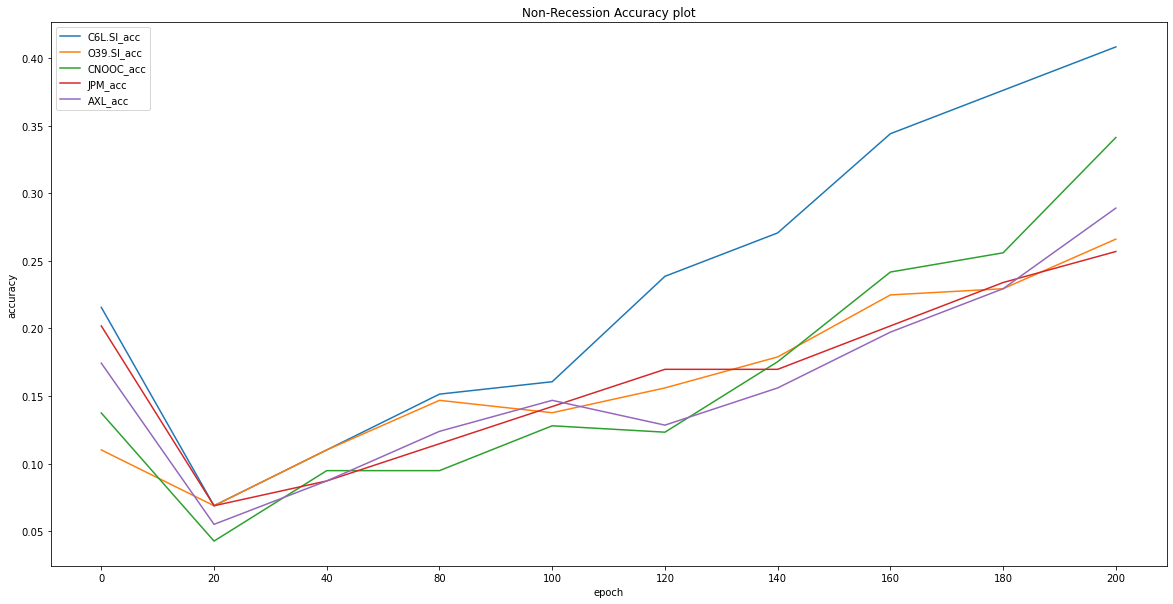

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

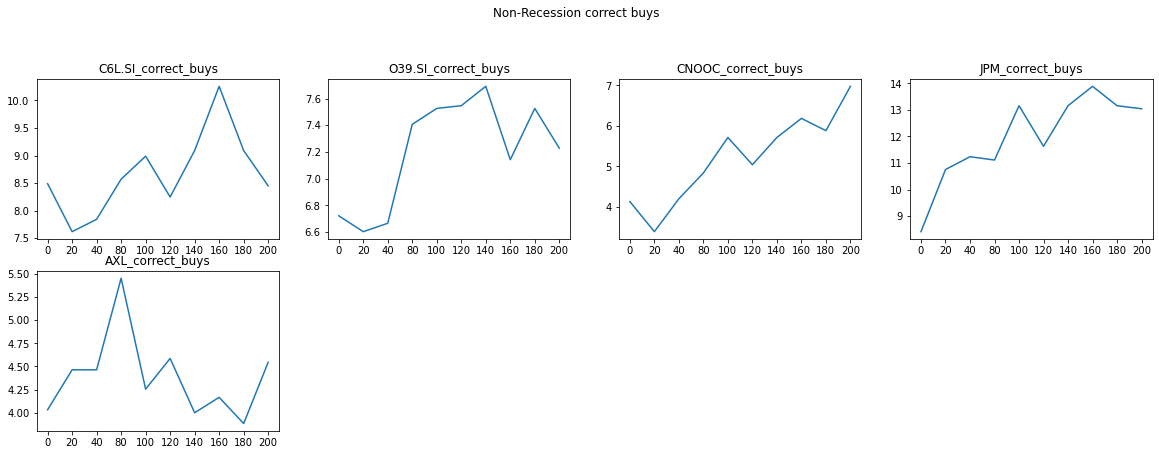

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

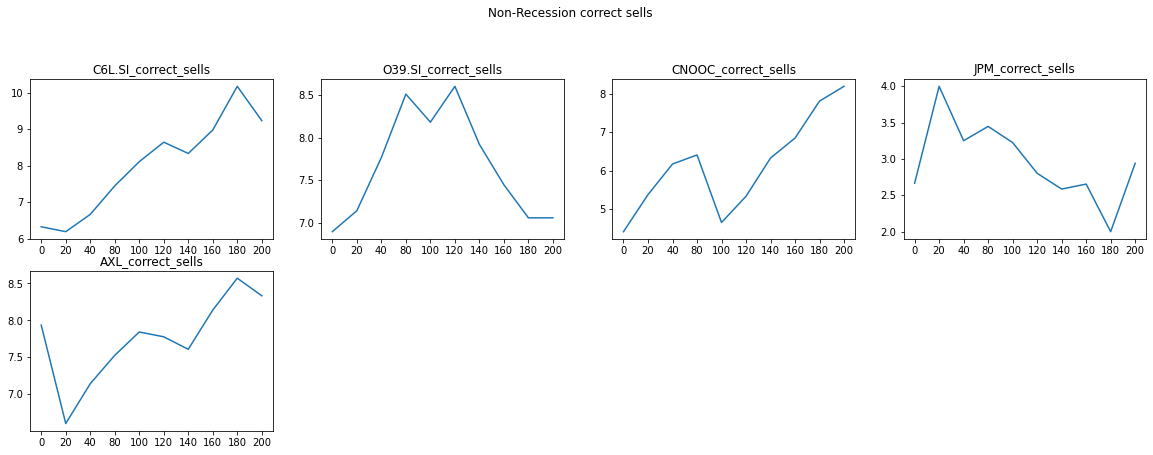

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

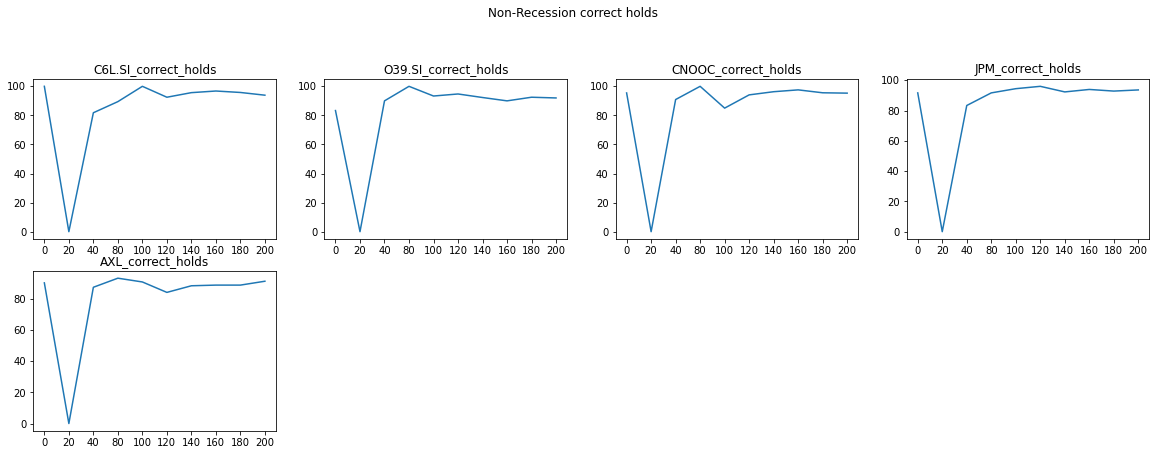

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

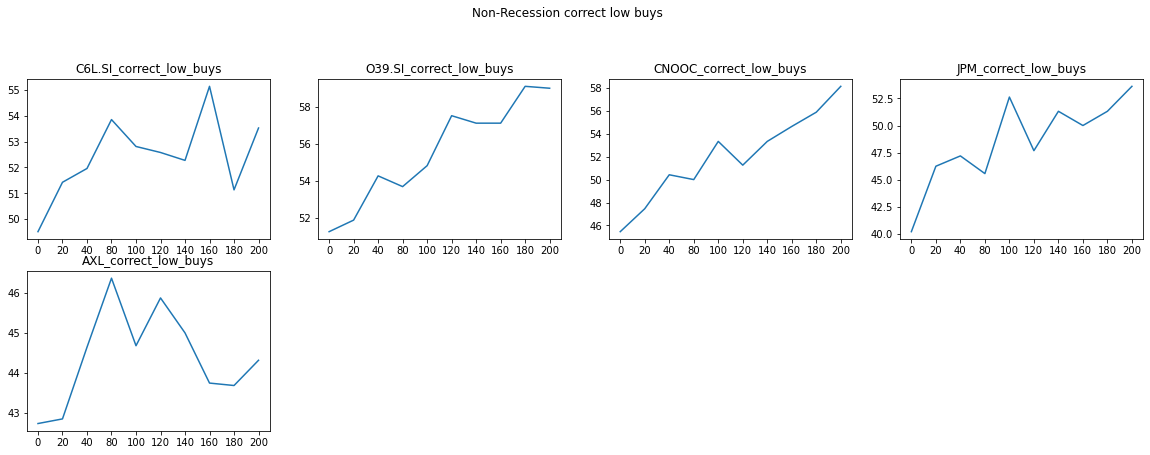

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

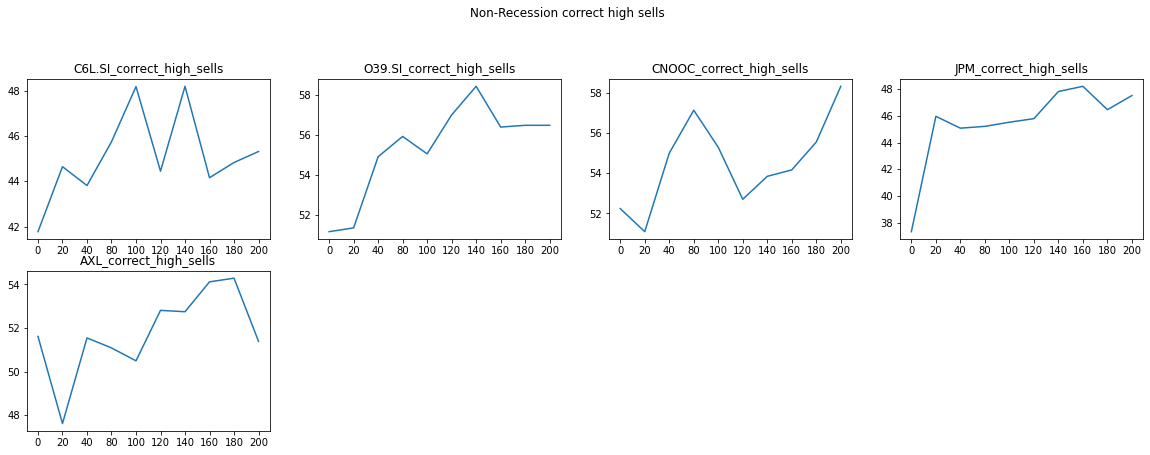

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

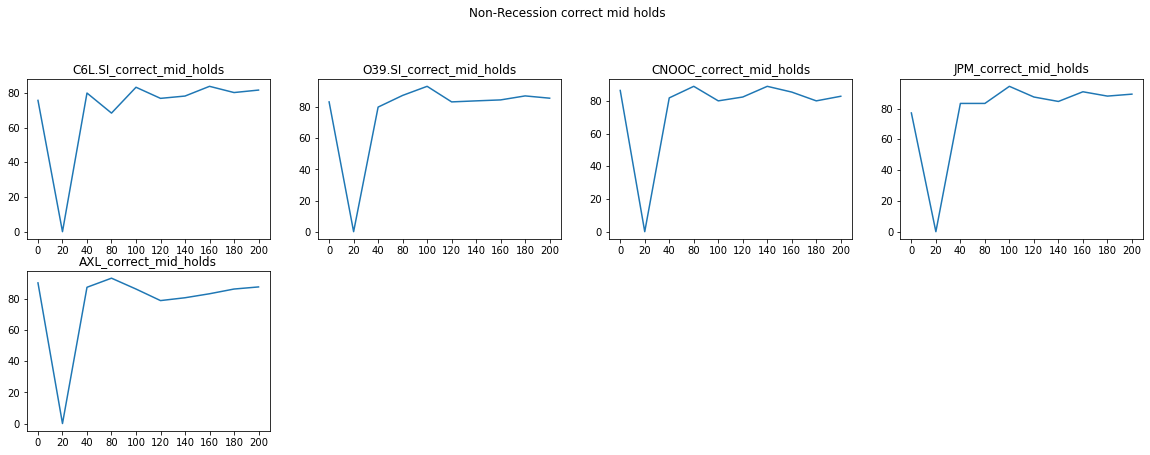

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

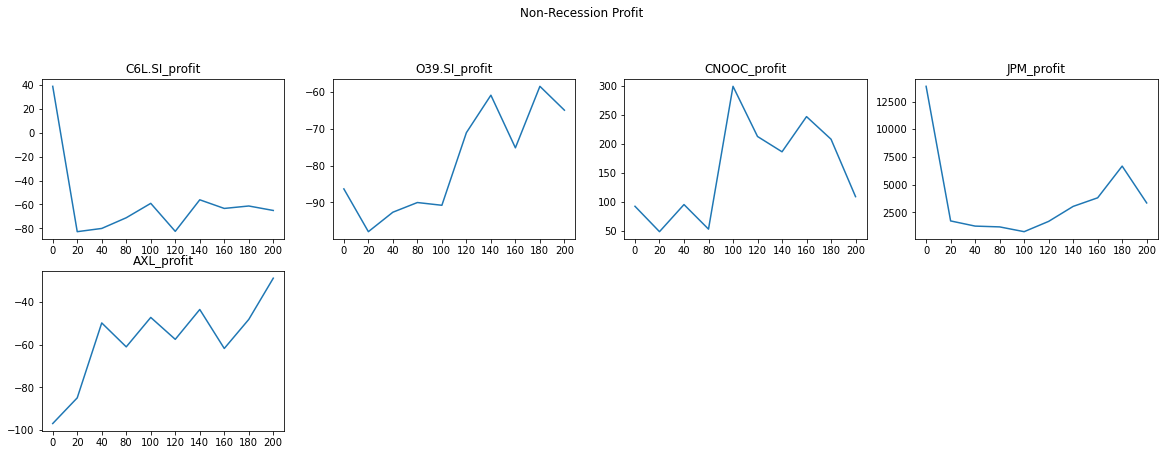

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [31]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


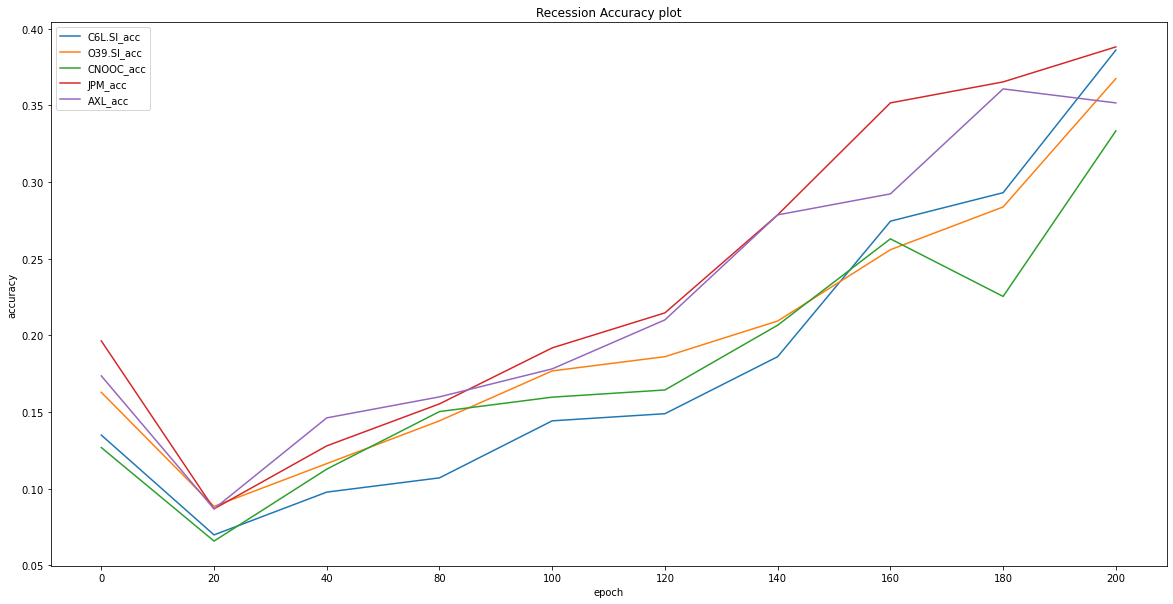

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

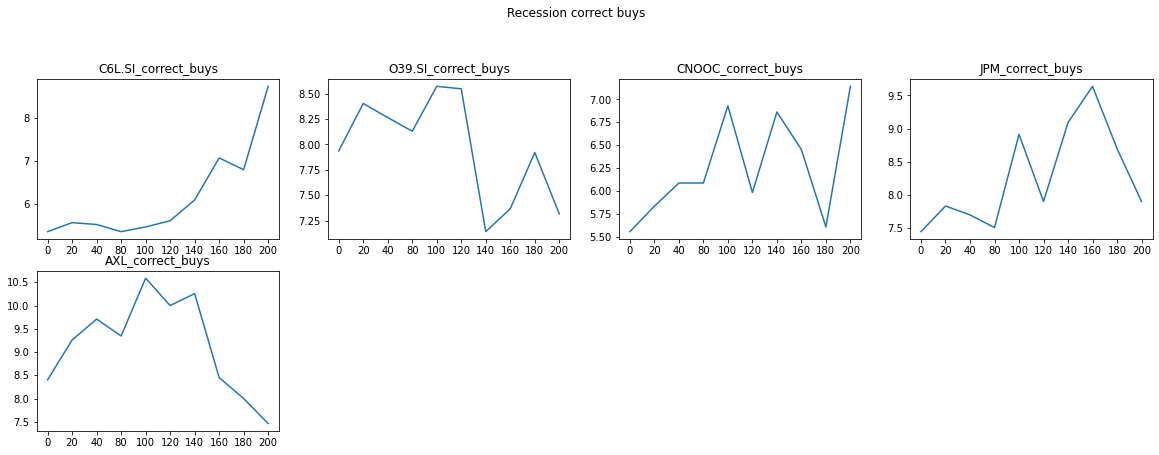

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

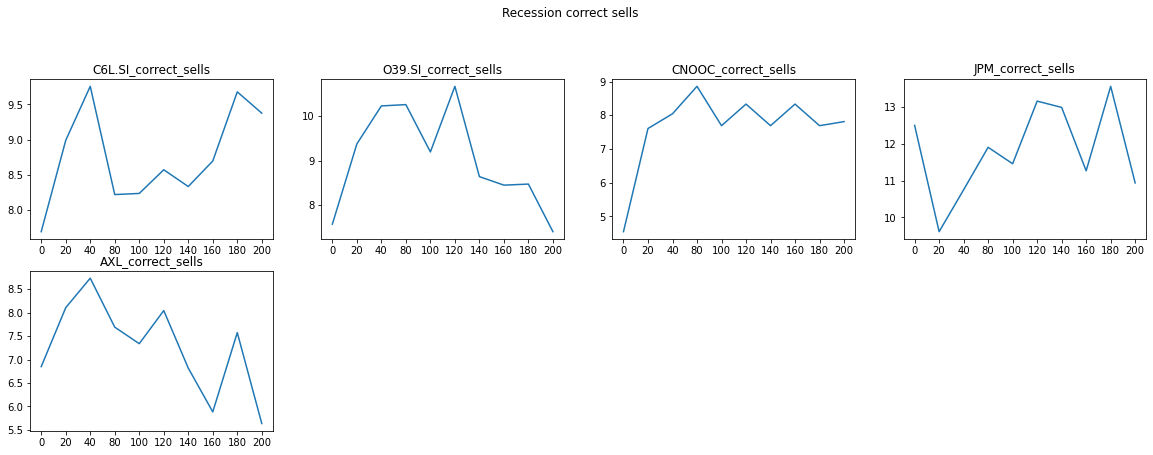

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

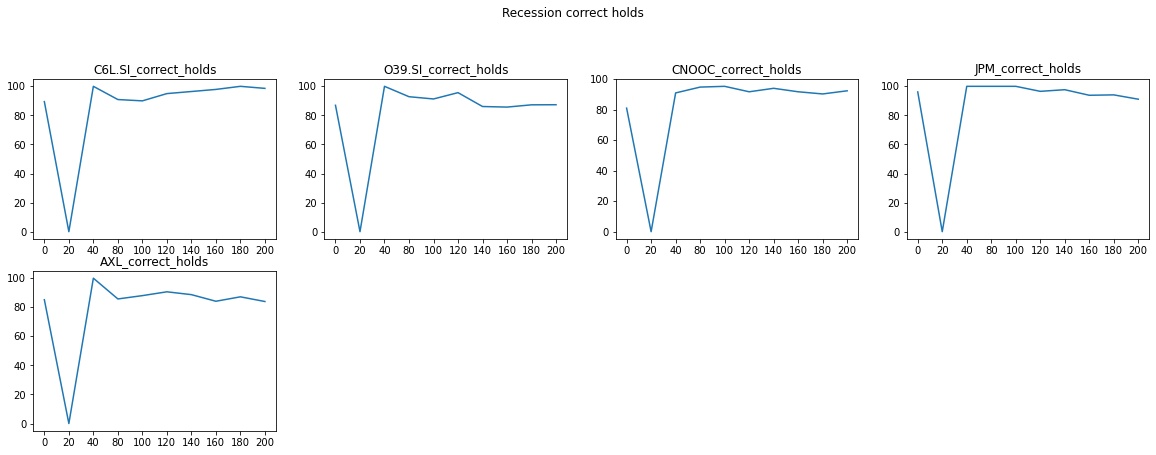

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

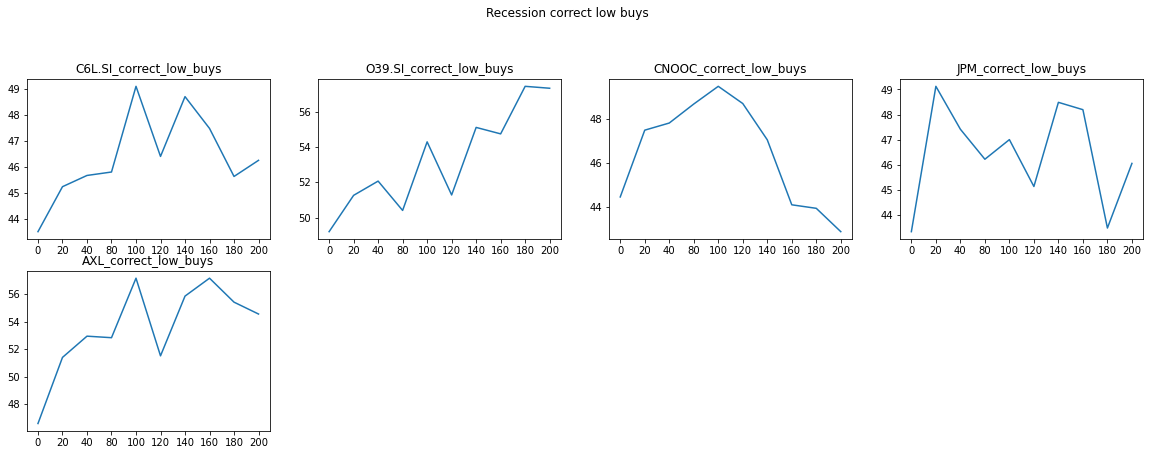

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

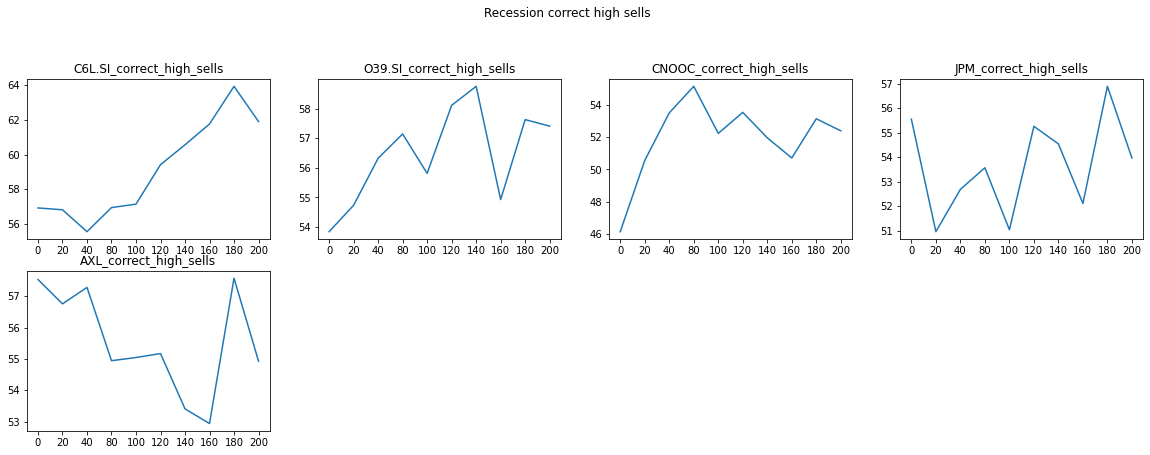

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

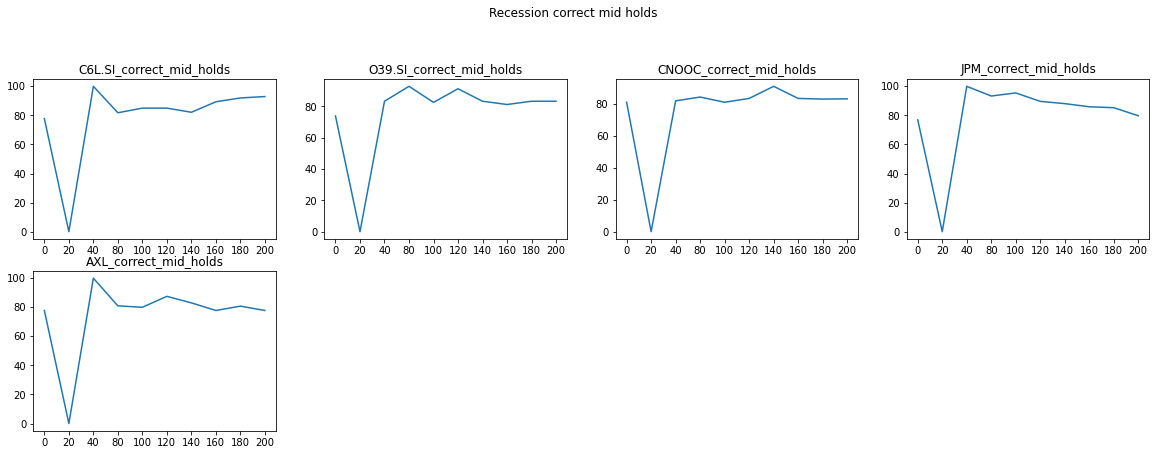

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

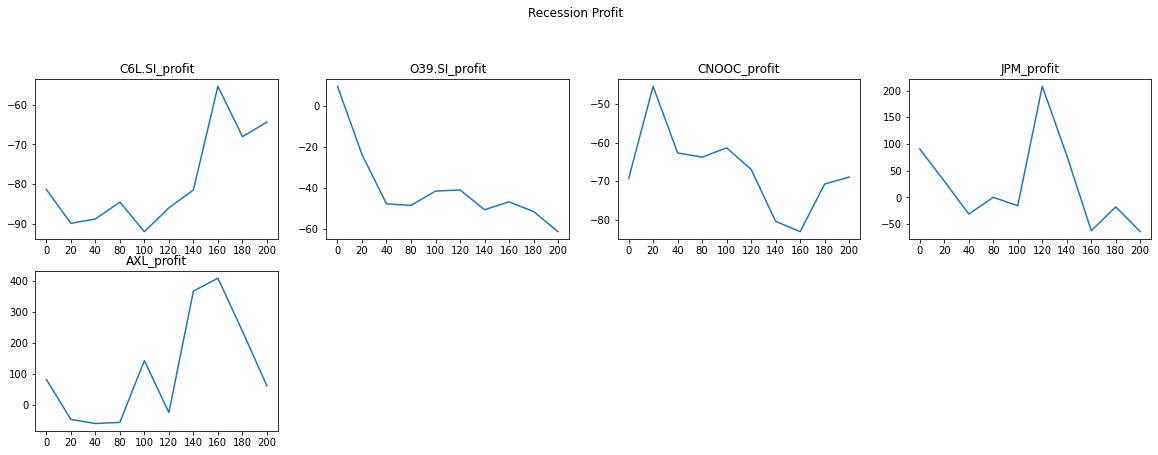

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")